In [1]:
import json
import pandas as pd
import seaborn as sns

from os.path import join
from matplotlib import pyplot as plt

In [2]:
def get_generator_stats(stat_file, stat_name):
    stats = json.load(stat_file)
    return stats["cores"]["generator"][stat_name]["value"]

In [3]:
def get_stat(stat_file, stat_name, dump_number):
    stat_file.seek(1)

    ret = 0
    begins_visited = 0
    reached_section = False
    for line in stat_file.readlines():
        if begins_visited == dump_number:
            reached_section = True
        if not reached_section:
            if line.startswith("---------- Begin Simulation Statistics ----------"):
                begins_visited += 1
        else:
            if line.startswith("---------- End Simulation Statistics   ----------"):
                break
            if stat_name in line:
                val_str = line.split()[1]
                if val_str != "nan":
                    ret += float(val_str)
    return ret

In [22]:
generators = ["Linear", "Random"]
intensities = ["Loaded", "Unloaded"]
memories = ["DDR3", "DDR4", "LPDDR3", "HBM"]
num_channels = ["1"]

%cd /home/msamani/darchr/mem-perf

stats = ["readBW", "avgReadLatency"]
def get_stat_file_name(generator, intensity, memory, num_channels):
    return f"results/memory_studies/{generator}/{intensity}/{memory}/{num_channels}/stats.txt", f"results/memory_studies/{generator}/{intensity}/{memory}/{num_channels}/processor_stats.json"

rows = []
for generator in generators:
    for intensity in intensities:
        for memory in memories:
            for num_chnls in num_channels:
                row = [memory, num_chnls, generator, intensity]
                stat_file_name, _ = get_stat_file_name(generator, intensity, memory, num_chnls)
                with open(stat_file_name, "r") as stat_file:
                    for stat in stats:
                        stat_val = get_stat(stat_file, stat, 0)
                        row.append(stat_val)
                rows.append(row)

memory_studies_data = pd.DataFrame(rows, columns = ["Memory", "Num Channels", "Generator", "Intensity"] + stats)
memory_studies_data["Bandwidth (GB/s)"] = memory_studies_data["readBW"] / 1073741824
memory_studies_data["Latency (ns)"] = memory_studies_data["avgReadLatency"] / 1000

/home/msamani/darchr/mem-perf


In [5]:
memory_studies_data.head(16)

,Memory,Num Channels,Generator,Intensity,readBW,avgReadLatency
0,DDR3,1,Linear,Loaded,9.234913,235.062847
1,DDR4,1,Linear,Loaded,12.988181,319.930804
2,LPDDR3,1,Linear,Loaded,4.338383,255.671117
3,HBM,1,Linear,Loaded,13.940861,163.366788
4,DDR3,1,Linear,Unloaded,0.999570,47.668566
5,DDR4,1,Linear,Unloaded,0.999570,50.508160
6,LPDDR3,1,Linear,Unloaded,0.998974,54.028950
7,HBM,1,Linear,Unloaded,0.999570,47.330611
8,DDR3,1,Random,Loaded,11.498188,193.236876
9,DDR4,1,Random,Loaded,17.033960,248.636906


In [19]:
cache_classes = ["NoCache", "PrivateL1", "PrivateL1PrivateL2", "MESITwoLevel"]
stats = ["readBW", "avgReadLatency"]

limits = ["32KiB", "256KiB", "1MiB"]

def get_stat_file_name_2(cache):
    return f"results/cache_studies/{cache}/stats.txt"

rows = []
for cache in cache_classes:
    stat_file_name = get_stat_file_name_2(cache)
    for i in range(3):
        row = [cache, limits[i]]
        with open(stat_file_name, "r") as stat_file:
            for stat in stats:
                val = get_stat(stat_file, stat, i)
                row.append(val)
        rows.append(row)

cache_studies_data = pd.DataFrame(rows, columns = ["Cache", "Access Range"] + stats)
cache_studies_data["Bandwidth (GB/s)"] = cache_studies_data["readBW"] / 1073741824
cache_studies_data["Latency (ns)"] = cache_studies_data["avgReadLatency"] / 1000

In [20]:
cache_studies_data.head(12)

,Cache,Access Range,readBW,avgReadLatency,Bandwidth (GB/s),Latency (ns)
0,NoCache,32KiB,0.0,0.000000,0.000000,0.000000
1,NoCache,256KiB,0.0,0.000000,0.000000,0.000000
2,NoCache,1MiB,0.0,0.000000,0.000000,0.000000
3,PrivateL1,32KiB,32768000.0,371.363281,0.030518,0.371363
4,PrivateL1,256KiB,32768000.0,371.363281,0.030518,0.371363
5,PrivateL1,1MiB,262144000.0,457.143066,0.244141,0.457143
6,PrivateL1PrivateL2,32KiB,32768000.0,371.363281,0.030518,0.371363
7,PrivateL1PrivateL2,256KiB,32768000.0,371.363281,0.030518,0.371363
8,PrivateL1PrivateL2,1MiB,262144000.0,407.523682,0.244141,0.407524
9,MESITwoLevel,32KiB,32768000.0,821.191406,0.030518,0.821191


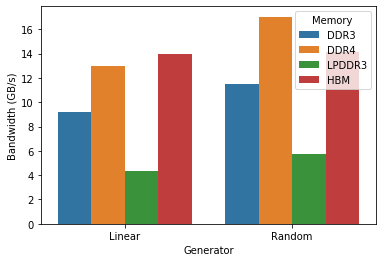

In [23]:
fig, axes = plt.subplots(1, 1, figsize = (6, 4))
local_data = memory_studies_data[(memory_studies_data["Num Channels"] == "1") & (memory_studies_data["Intensity"] == "Loaded")]
ax = sns.barplot(ax = axes, x = "Generator", y = "Bandwidth (GB/s)", hue = "Memory", data = local_data)


(0, 325)

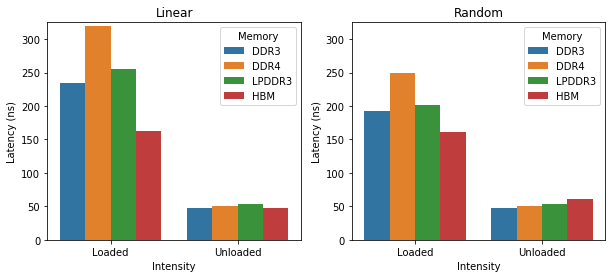

In [25]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
local_data = memory_studies_data[(memory_studies_data["Num Channels"] == "1") & (memory_studies_data["Generator"] == "Linear")]
ax = sns.barplot(ax = axes[0], x = "Intensity", y = "Latency (ns)", hue = "Memory", data = local_data)
axes[0].set_title("Linear")
axes[0].set_ylim(0,325)
local_data = memory_studies_data[(memory_studies_data["Num Channels"] == "1") & (memory_studies_data["Generator"] == "Random")]
ax = sns.barplot(ax = axes[1], x = "Intensity", y = "Latency (ns)", hue = "Memory", data = local_data)
axes[1].set_title("Random")
axes[1].set_ylim(0,325)

<AxesSubplot:xlabel='Cache', ylabel='avgReadLatency'>

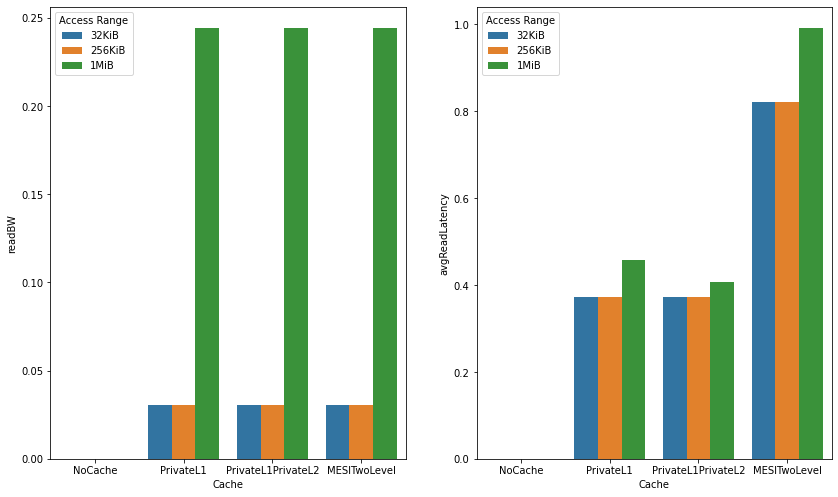

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (14, 8.32))
sns.barplot(ax = axes[0], x = "Cache", y = "readBW", hue = "Access Range", data = cache_studies_data)
sns.barplot(ax = axes[1], x = "Cache", y = "avgReadLatency", hue = "Access Range", data = cache_studies_data)